In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso 

# Own code

In [8]:
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4


def create_X(x, y, n):
    """Returns the design matrix X from coordinates x and y with n polynomial degrees."""
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # Number of elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int(i * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x**(i - k)) * (y**k)

    return X


def MSE(y, y_tilde):
    """Returns the mean squared error of the two arrays."""
    return np.mean((y - y_tilde)**2)


def R2_score(y, y_tilde):
    """Returns the R2 score of the two arrays."""
    return 1 - np.sum((y - y_tilde)**2) / np.sum((y - np.mean(y))**2)
# PARAMETERS
N = 1000  # number of data points
maxdegree = 6  # max polynomial degree for plotting


# Create data set
np.random.seed(2023)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

# Get franke function with noise
noise = np.random.normal(0, 0.1, x.shape)
z = FrankeFunction(x, y) + noise

""" Below is a function for each method OLS, Ridge and Lasso. 

    Args
    
    OLS_model(maxdegree, input_folds):
        Takes in maximum degree of polynomials (int) and number of folds (int)

    Ridge_model(maxdegree, lamb, input_folds):
        Takes in maximum degree of polynomials (int), lambda value (float) and number of folds (int)

    Lasse_model(maxdergee, input_folds):
        Takes in maximum degree of polynomials (int) and number of folds (int)
    
    
    Return 

    Each function returns the methods MSE value.

"""

def OLS_model(maxdegree, input_folds):
    scaler = StandardScaler()
    
    degrees = np.arange(0, maxdegree, 1)
    train_mse = np.empty(degrees.shape)
    test_mse = np.empty_like(train_mse)
    train_r2 = np.empty_like(train_mse)
    test_r2 = np.empty_like(train_mse)
    beta_arr = []
    
    # Iterate through all the different polynomial degrees
    for degree in degrees:
        
        # Create design matrix X
        X = create_X(x, y, n=degree)  # intercept included
    
        degrees_fold = np.arange(0, maxdegree, 1)
        train_mse_fold = np.empty(degrees.shape)
        test_mse_fold = np.empty_like(train_mse)
        train_r2_fold = np.empty_like(train_mse)
        test_r2_fold = np.empty_like(train_mse)
    
        
        """ Implementing cross validation for n_folds. Using the KFold from 
            sklearn.model_selection to split the data into two pieces
            train and test, given the input value n_splits which determines how many folds 
            with train and test pairs are created. 
        
            The loops uses two iterators train and test to loop through KFold and extracts 
            the indexes for the train and test arrays. Thus the iterators are essentially 
            extracting the elements indexes of the matrix. Furthermore, the MSE and R2 scores
            are calculated for each fold and then they are taken the mean of before plotted.
            
            Inspired from (codebasics, 2019)
        """
    
        n_folds = input_folds
        kf = KFold(n_splits=n_folds)
        for train, test in kf.split(X):
            X_train, X_test, z_train, z_test = X[train], X[test], z[train], z[test]
            
            # Scale data
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
            # Ordinary least squares linear regression
            beta = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ z_train
            z_tilde = X_train_scaled @ beta
            z_predict = X_test_scaled @ beta
            #print(z_tilde.shape)
    
            # Store the MSE and R2 values
            train_mse_fold[degree] = MSE(z_train, z_tilde)
            test_mse_fold[degree] = MSE(z_test, z_predict)
            train_r2_fold[degree] = R2_score(z_train, z_tilde)
            test_r2_fold[degree] = R2_score(z_test, z_predict)
        
        # Store beta value for plotting
        beta_arr.append(beta)
        
        # Store the MSE and R2 values
        train_mse[degree] = np.mean(train_mse_fold)
        test_mse[degree] = np.mean(test_mse_fold)
        train_r2[degree] = np.mean(train_r2_fold)
        test_r2[degree] = np.mean(test_r2_fold)

    return test_mse

def Ridge_model(maxdegree, lamb, input_folds):
    scaler = StandardScaler()
    
    degrees = np.arange(0, maxdegree, 1)
    train_mse = np.empty(degrees.shape)
    test_mse = np.empty_like(train_mse)
    train_r2 = np.empty_like(train_mse)
    test_r2 = np.empty_like(train_mse)
    beta_arr = []
    
    # Iterate through all the different polynomial degrees
    for degree in degrees:
        
        # Create design matrix X
        X = create_X(x, y, n=degree)  # intercept included
    
        degrees_fold = np.arange(0, maxdegree, 1)
        train_mse_fold = np.empty(degrees.shape)
        test_mse_fold = np.empty_like(train_mse)
        train_r2_fold = np.empty_like(train_mse)
        test_r2_fold = np.empty_like(train_mse)
    
        
        """ Implementing cross validation for n_folds. Using the KFold from 
            sklearn.model_selection to split the data into two pieces
            train and test, given the input value n_splits which determines how many folds 
            with train and test pairs are created. 
        
            The loops uses two iterators train and test to loop through KFold and extracts 
            the indexes for the train and test arrays. Thus the iterators are essentially 
            extracting the elements indexes of the matrix. Furthermore, the MSE and R2 scores
            are calculated for each fold and then they are taken the mean of before plotted.
            
            Inspired from (codebasics, 2019)
        """
    
        n_folds = input_folds
        kf = KFold(n_splits=n_folds)
        for train, test in kf.split(X):
            X_train, X_test, z_train, z_test = X[train], X[test], z[train], z[test]
            
            # Scale data
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            I = np.identity(X_train.shape[1])
            # Ridge linear regression
            beta_rid = np.linalg.pinv(X_train_scaled.T @ X_train_scaled + lamb * I) @ X_train_scaled.T @ z_train
            z_tilde = X_train_scaled @ beta_rid
            z_predict = X_test_scaled @ beta_rid
            #print(z_tilde.shape)
    
            # Store the MSE and R2 values
            train_mse_fold[degree] = MSE(z_train, z_tilde)
            test_mse_fold[degree] = MSE(z_test, z_predict)
            train_r2_fold[degree] = R2_score(z_train, z_tilde)
            test_r2_fold[degree] = R2_score(z_test, z_predict)
        
        # Store the MSE and R2 values
        train_mse[degree] = np.mean(train_mse_fold)
        test_mse[degree] = np.mean(test_mse_fold)
        train_r2[degree] = np.mean(train_r2_fold)
        test_r2[degree] = np.mean(test_r2_fold)

    return test_mse

def Lasse_model(maxdergee, input_folds):
    scaler = StandardScaler()
    
    degrees = np.arange(0, maxdegree, 1)
    train_mse = np.empty(degrees.shape)
    test_mse = np.empty_like(train_mse)
    train_r2 = np.empty_like(train_mse)
    test_r2 = np.empty_like(train_mse)
    beta_arr = []
    
    # Iterate through all the different polynomial degrees
    for degree in degrees:
        
        # Create design matrix X
        X = create_X(x, y, n=degree)  # intercept included
    
        degrees_fold = np.arange(0, maxdegree, 1)
        train_mse_fold = np.empty(degrees.shape)
        test_mse_fold = np.empty_like(train_mse)
        train_r2_fold = np.empty_like(train_mse)
        test_r2_fold = np.empty_like(train_mse)
    
        
        """ Implementing cross validation for n_folds. Using the KFold from 
            sklearn.model_selection to split the data into two pieces
            train and test, given the input value n_splits which determines how many folds 
            with train and test pairs are created. 
        
            The loops uses two iterators train and test to loop through KFold and extracts 
            the indexes for the train and test arrays. Thus the iterators are essentially 
            extracting the elements indexes of the matrix. Furthermore, the MSE and R2 scores
            are calculated for each fold and then they are taken the mean of before plotted.
            
            Inspired from (codebasics, 2019)
        """
    
        n_folds = input_folds
        kf = KFold(n_splits=n_folds)
        for train, test in kf.split(X):
            X_train, X_test, z_train, z_test = X[train], X[test], z[train], z[test]
            
            # Scale data
            scaler.fit(X_train)
            lasso = Lasso(fit_intercept=False)  # include intercept
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)

           
            # Lasso linear regression
            lasso.fit(X_train_scaled, z_train)
            z_tilde = lasso.predict(X_train_scaled)
            z_predict = lasso.predict(X_test_scaled)
            #print(z_tilde.shape)
    
            # Store the MSE and R2 values
            train_mse_fold[degree] = MSE(z_train, z_tilde)
            test_mse_fold[degree] = MSE(z_test, z_predict)
            train_r2_fold[degree] = R2_score(z_train, z_tilde)
            test_r2_fold[degree] = R2_score(z_test, z_predict)
        
       
        # Store the MSE and R2 values
        train_mse[degree] = np.mean(train_mse_fold)
        test_mse[degree] = np.mean(test_mse_fold)
        train_r2[degree] = np.mean(train_r2_fold)
        test_r2[degree] = np.mean(test_r2_fold)

    return test_mse





# Plotting the methods for specific fold

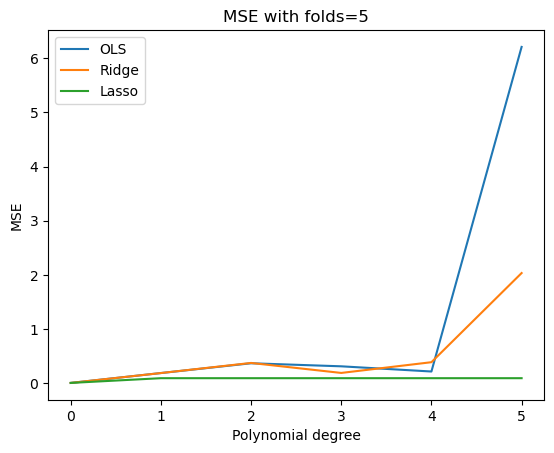

In [20]:
# Figure output directory
RESULTS_DIR = Path("../results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()

input_folds = 5
lamb = 0.0001 #lambda input for ridge regression
maxdegree = 6
degrees = np.arange(0, maxdegree, 1)

test_OLS = OLS_model(maxdegree, input_folds)
test_Ridge = Ridge_model(maxdegree, lamb, input_folds)
test_Lasso = Lasse_model(maxdegree, input_folds)

plt.plot(degrees, test_OLS, label="OLS")
plt.plot(degrees, test_Ridge, label="Ridge")
plt.plot(degrees, test_Lasso, label="Lasso")
plt.title(f"MSE with folds={input_folds}")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.legend()

plt.savefig(FIGURES_DIR / "part_f_MSE_allmethods.png")

# Loop for plotting folds 5-10

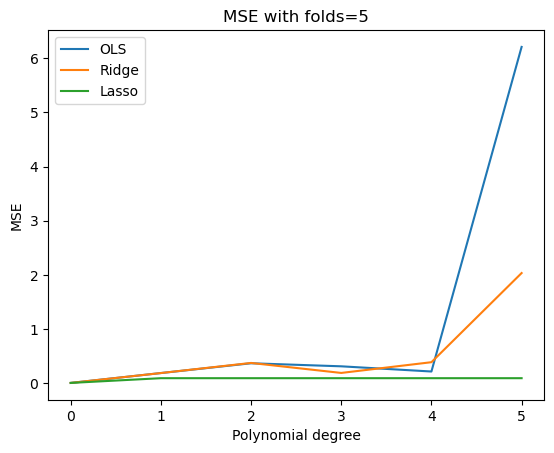

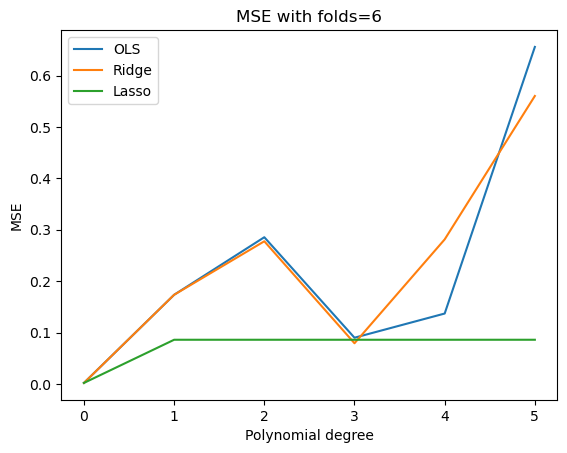

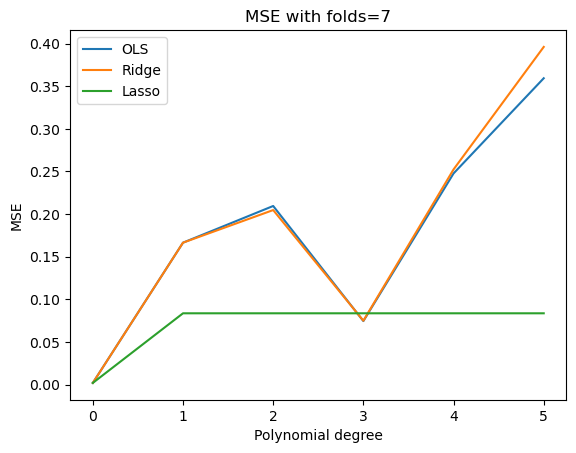

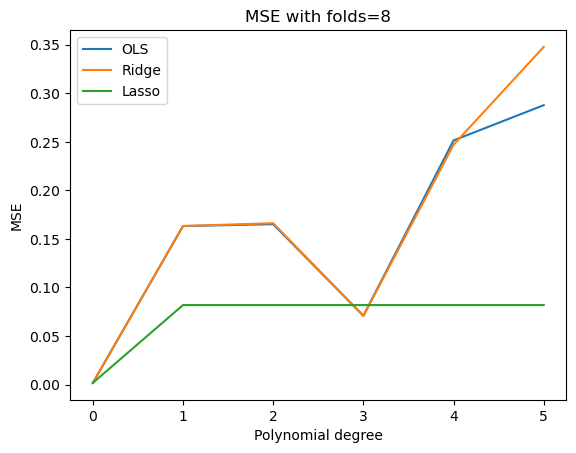

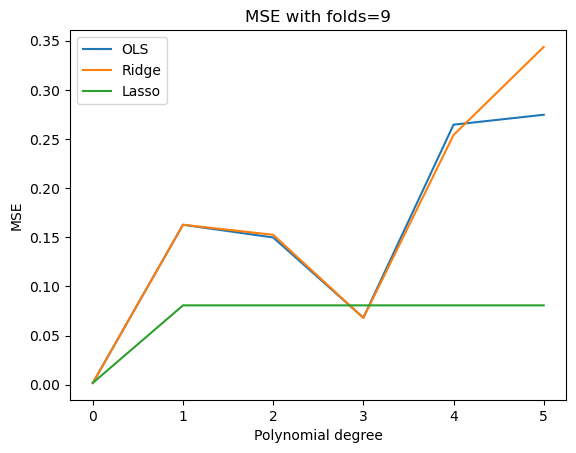

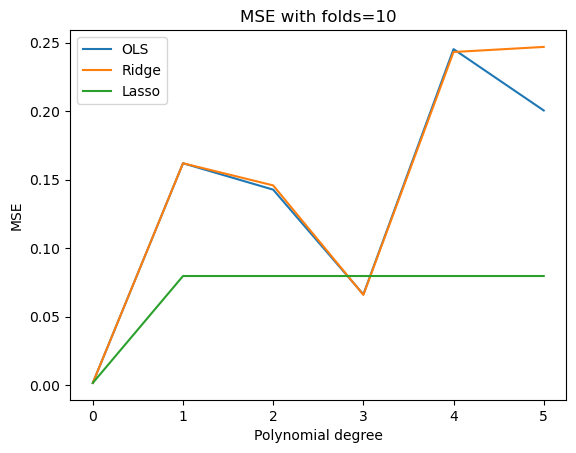

In [25]:
for i in range(5,11):
    input_folds = i
    lamb = 0.0001 #lambda input for ridge regression
    maxdegree = 6
    degrees = np.arange(0, maxdegree, 1)
    
    test_OLS = OLS_model(maxdegree, input_folds)
    test_Ridge = Ridge_model(maxdegree, lamb, input_folds)
    test_Lasso = Lasse_model(maxdegree, input_folds)
    
    plt.plot(degrees, test_OLS, label="OLS")
    plt.plot(degrees, test_Ridge, label="Ridge")
    plt.plot(degrees, test_Lasso, label="Lasso")
    plt.title(f"MSE with folds={input_folds}")
    plt.xlabel("Polynomial degree")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()